In [1]:
from omegaconf import OmegaConf as om
from scgpt.model import ComposerSCGPTModel
from scgpt.tasks import get_batch_cell_embeddings
from scgpt.tokenizer import GeneVocab
import torch
import scanpy as sc
import numpy as np
import os

/home/shreshth/miniforge3/envs/composer_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_paths= {
"scgpt-70m-2048": "/vevo/scgpt/checkpoints/release/scgpt-70m-2048/",
"scgpt-70m-1024": "/vevo/scgpt/checkpoints/release/scgpt-70m-1024/",
"scgpt-70m-1024-cell-cond": "/vevo/scgpt/checkpoints/release/scgpt-70m-1024-cell-cond/",
"scgpt-70m-1024-right-bin": "/vevo/scgpt/checkpoints/release/scgpt-70m-1024-right-bin"
} 
# At the moment only these 4 models have been prepared for inference
# For a new model, the wandb config needs to be split into model and collator configs and the latest
# checkpoint needs to be saved in the folder as best-model.pt

model_name = "scgpt-70m-2048"

In [3]:
model_config_path = os.path.join(model_paths[model_name], "model_config.yml")
vocab_path = os.path.join(model_paths[model_name], "vocab.json")
collator_config_path = os.path.join(model_paths[model_name], "collator_config.yml")
model_file =  os.path.join(model_paths[model_name], "best-model.pt")

In [4]:
model_config = om.load(model_config_path)
collator_config = om.load(collator_config_path)
vocab = GeneVocab.from_file(vocab_path)

model = ComposerSCGPTModel(model_config = model_config,
                          collator_config = collator_config)

In [5]:
model.load_state_dict(torch.load(model_file)["state"]["model"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

ComposerSCGPTModel(
  (model): SCGPTModel(
    (gene_encoder): GeneEncoder(
      (embedding): Embedding(60736, 512, padding_idx=60694)
    )
    (flag_encoder): Embedding(2, 512)
    (expression_encoder): ContinuousValueEncoder(
      (dropout): Dropout(p=0.1, inplace=False)
      (linear1): Linear(in_features=1, out_features=512, bias=True)
      (linear2): Linear(in_features=512, out_features=512, bias=True)
    )
    (transformer_encoder): SCGPTEncoder(
      (layers): ModuleList(
        (0-11): 12 x SCGPTBlock(
          (self_attn): GroupedQueryAttention(
            (Wqkv): Linear(in_features=512, out_features=1536, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (up_proj): Linear(in_features=512, out_features=2048, bias=True)
          (down_proj): Linear(in_features=2048, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e

In [6]:
sample_data_path = '/vevo/scgpt/datasets/samples/Kim2020_Lung.h5ad'
adata = sc.read_h5ad(sample_data_path)

gene_col = "gene_name"
cell_type_key = "cell_type"
batch_key = "sample"
N_HVG = 3000

In [7]:
celltype_id_labels = adata.obs[cell_type_key].astype("category").cat.codes.values
adata = adata[celltype_id_labels >= 0]
org_adata = adata.copy()
# highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=N_HVG, flavor='seurat_v3')
adata = adata[:, adata.var['highly_variable']]

/home/shreshth/miniforge3/envs/composer_env/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:151: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": "seurat_v3"}


In [8]:
adata.var["id_in_vocab"] = [
    vocab[gene] if gene in vocab else -1 for gene in adata.var[gene_col]
]
gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
print(
    f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
    f"in vocabulary of size {len(vocab)}."
)
adata = adata[:, adata.var["id_in_vocab"] >= 0]

vocab.set_default_index(vocab["<pad>"])
genes = adata.var[gene_col].tolist()
gene_ids = np.array(vocab(genes), dtype=int)

/tmp/ipykernel_1628248/55725197.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["id_in_vocab"] = [


match 2978/3000 genes in vocabulary of size 60736.


In [9]:
# get cell embeddings
cell_embeddings = get_batch_cell_embeddings(
    adata=adata,
    model=model.model,
    vocab=vocab,
    gene_ids=gene_ids,
    model_cfg=model_config,
    collator_cfg=collator_config,
    batch_size=32,
)


adata.obsm["X_scGPT"] = cell_embeddings

Embedding cells: 100%|██████████| 953/953 [00:44<00:00, 21.32it/s]
/tmp/ipykernel_1628248/489859615.py:13: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings


/home/shreshth/miniforge3/envs/composer_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/shreshth/miniforge3/envs/composer_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/shreshth/miniforge3/envs/composer_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vec

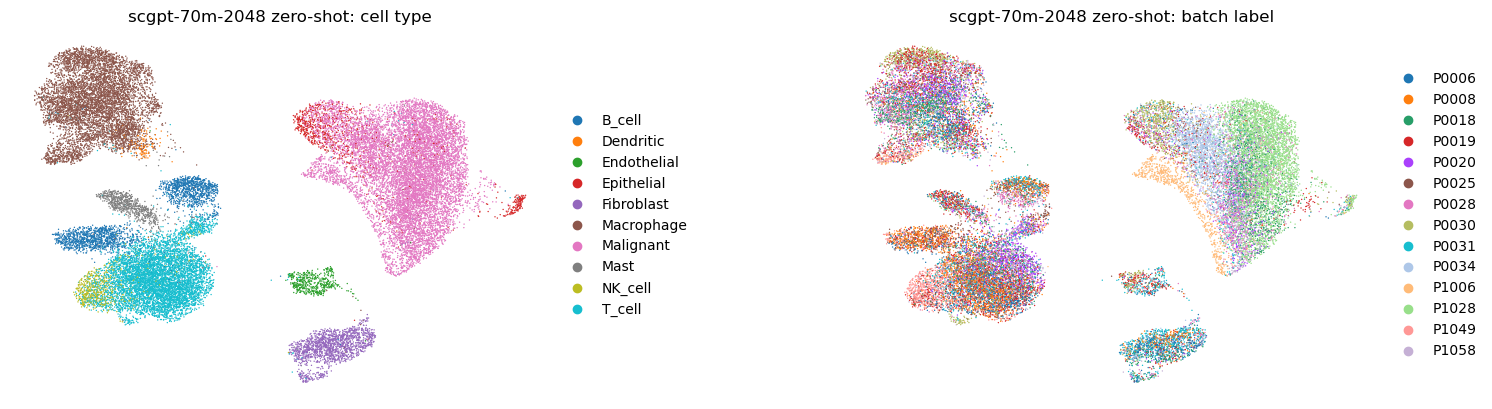

In [11]:
sc.pp.neighbors(adata, use_rep="X_scGPT")
sc.tl.umap(adata)
sc.pl.umap(adata, 
           color=[cell_type_key, batch_key], 
           frameon=False, 
           wspace=0.4, 
           title=[f"{model_name} zero-shot: cell type", f"{model_name} zero-shot: batch label"])